In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau

from keras.utils import to_categorical
from keras import layers
from keras import models
from keras import optimizers

Using TensorFlow backend.


In [2]:
(train_data,train_label),(test_data,test_label)=mnist.load_data()

print(f'The Train Data shape : {train_data.shape}')
print(f'The Test Data shape : {test_data.shape}')

The Train Data shape : (60000, 28, 28)
The Test Data shape : (10000, 28, 28)


In [3]:
train_data = train_data.reshape(-1,28,28,1).astype('float32')/255
test_data = test_data.reshape(-1,28,28,1).astype('float32')/255

In [4]:
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

In [5]:
train_data,val_data,train_label,val_label=train_test_split(train_data,train_label,test_size=0.25,random_state=13)

In [6]:
LR_function=ReduceLROnPlateau(monitor='val_acc',
                             patience=3,
                             verbose=1,
                             factor=0.5,
                             min_lr=0.00001)

In [7]:
import os
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPool2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
import numpy as np


def channel_split(x, name=''):
    # equipartition
    in_channles = x.shape.as_list()[-1]
    ip = in_channles // 2
    c_hat = Lambda(lambda z: z[:, :, :, 0:ip], name='%s/sp%d_slice' % (name, 0))(x)
    c = Lambda(lambda z: z[:, :, :, ip:], name='%s/sp%d_slice' % (name, 1))(x)
    return c_hat, c

def channel_shuffle(x):
    height, width, channels = x.shape.as_list()[1:]
    channels_per_split = channels // 2
    x = K.reshape(x, [-1, height, width, 2, channels_per_split])
    x = K.permute_dimensions(x, (0,1,2,4,3))
    x = K.reshape(x, [-1, height, width, channels])
    return x


def shuffle_unit(inputs, out_channels, bottleneck_ratio,strides=2,stage=1,block=1):
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        raise ValueError('Only channels last supported')

    prefix = 'stage{}/block{}'.format(stage, block)
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    if strides < 2:
        c_hat, c = channel_split(inputs, '{}/spl'.format(prefix))
        inputs = c

    x = Conv2D(bottleneck_channels, kernel_size=(1,1), strides=1, padding='same', name='{}/1x1conv_1'.format(prefix))(inputs)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_1'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_1'.format(prefix))(x)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', name='{}/3x3dwconv'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv'.format(prefix))(x)
    x = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1conv_2'.format(prefix))(x)
    x = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_2'.format(prefix))(x)
    x = Activation('relu', name='{}/relu_1x1conv_2'.format(prefix))(x)

    if strides < 2:
        ret = Concatenate(axis=bn_axis, name='{}/concat_1'.format(prefix))([x, c_hat])
    else:
        s2 = DepthwiseConv2D(kernel_size=3, strides=2, padding='same', name='{}/3x3dwconv_2'.format(prefix))(inputs)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_3x3dwconv_2'.format(prefix))(s2)
        s2 = Conv2D(bottleneck_channels, kernel_size=1,strides=1,padding='same', name='{}/1x1_conv_3'.format(prefix))(s2)
        s2 = BatchNormalization(axis=bn_axis, name='{}/bn_1x1conv_3'.format(prefix))(s2)
        s2 = Activation('relu', name='{}/relu_1x1conv_3'.format(prefix))(s2)
        ret = Concatenate(axis=bn_axis, name='{}/concat_2'.format(prefix))([x, s2])

    ret = Lambda(channel_shuffle, name='{}/channel_shuffle'.format(prefix))(ret)

    return ret


def block(x, channel_map, bottleneck_ratio, repeat=1, stage=1):
    x = shuffle_unit(x, out_channels=channel_map[stage-1],
                      strides=2,bottleneck_ratio=bottleneck_ratio,stage=stage,block=1)

    for i in range(1, repeat+1):
        x = shuffle_unit(x, out_channels=channel_map[stage-1],strides=1,
                          bottleneck_ratio=bottleneck_ratio,stage=stage, block=(1+i))

    return x


In [8]:
import numpy as np
from keras.utils import plot_model
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense
from keras.models import Model
import keras.backend as K



def ShuffleNetV2(include_top=True,
                 input_tensor=None,
                 scale_factor=1.0,
                 pooling='max',
                 input_shape=(224,224,3),
                 load_model=None,
                 num_shuffle_units=[3,7,3],
                 bottleneck_ratio=1,
                 classes=1000):
    if K.backend() != 'tensorflow':
        raise RuntimeError('Only tensorflow supported for now')
    name = 'ShuffleNetV2_{}_{}_{}'.format(scale_factor, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))
    input_shape = _obtain_input_shape(input_shape, default_size=224, min_size=28, require_flatten=include_top,
                                      data_format=K.image_data_format())
    out_dim_stage_two = {0.5:48, 1:116, 1.5:176, 2:244}

    if pooling not in ['max', 'avg']:
        raise ValueError('Invalid value for pooling')
    if not (float(scale_factor)*4).is_integer():
        raise ValueError('Invalid value for scale_factor, should be x over 4')
    exp = np.insert(np.arange(len(num_shuffle_units), dtype=np.float32), 0, 0)  # [0., 0., 1., 2.]
    out_channels_in_stage = 2**exp
    out_channels_in_stage *= out_dim_stage_two[bottleneck_ratio]  #  calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same', use_bias=False, strides=(2, 2),
               activation='relu', name='conv1')(img_input)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = block(x, out_channels_in_stage,
                   repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   stage=stage + 2)

    if bottleneck_ratio < 2:
        k = 1024
    else:
        k = 2048
    x = Conv2D(k, kernel_size=1, padding='same', strides=1, name='1x1conv5_out', activation='relu')(x)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name='global_max_pool')(x)

    if include_top:
        x = Dense(classes, name='fc')(x)
        x = Activation('softmax', name='softmax')(x)

    if input_tensor:
        inputs = get_source_inputs(input_tensor)

    else:
        inputs = img_input

    model = Model(inputs, x, name=name)

    if load_model:
        model.load_weights('', by_name=True)

    return model

if __name__ == '__main__':
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    model = ShuffleNetV2(include_top=True, input_shape=(28,28,1), bottleneck_ratio=1)
    plot_model(model, to_file='shufflenetv2.jpg', show_layer_names=True, show_shapes=True)


    pass


In [9]:


model=ShuffleNetV2(input_shape=(28,28,1),classes=10)


model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 24)   216         input_2[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 7, 7, 24)     0           conv1[0][0]                      
__________________________________________________________________________________________________
stage2/block1/1x1conv_1 (Conv2D (None, 7, 7, 116)    2900        maxpool1[0][0]                   
__________________________________________________________________________________________________
stage2/blo

In [10]:
model.compile(optimizer='Adam' , loss='categorical_crossentropy' , metrics=['accuracy'])

In [11]:
history = model.fit(train_data , train_label , epochs=100 , batch_size=64,validation_data=[val_data,val_label],callbacks=[LR_function])

Train on 45000 samples, validate on 15000 samples
Epoch 1/100
45000/45000 [==============================] - 56s 1ms/step - loss: 0.3614 - acc: 0.8873 - val_loss: 0.1647 - val_acc: 0.9509
Epoch 2/100
45000/45000 [==============================] - 42s 944us/step - loss: 0.1276 - acc: 0.9624 - val_loss: 0.1291 - val_acc: 0.9619
Epoch 3/100
45000/45000 [==============================] - 47s 1ms/step - loss: 0.0972 - acc: 0.9713 - val_loss: 0.0930 - val_acc: 0.9740
Epoch 4/100
45000/45000 [==============================] - 47s 1ms/step - loss: 0.0702 - acc: 0.9794 - val_loss: 0.1482 - val_acc: 0.9557
Epoch 5/100
45000/45000 [==============================] - 53s 1ms/step - loss: 0.0967 - acc: 0.9730 - val_loss: 0.2165 - val_acc: 0.9433
Epoch 6/100
45000/45000 [==============================] - 52s 1ms/step - loss: 0.0667 - acc: 0.9804 - val_loss: 0.0710 - val_acc: 0.9781
Epoch 7/100
45000/45000 [==============================] - 46s 1ms/step - loss: 0.0456 - acc: 0.9863 - val_loss: 0.0734 

In [12]:
loss,acc=model.evaluate(test_data,test_label)
print(f'The Accuracy on Test Data = {acc}')

10000/10000 [==============================] - 3s 336us/step
The Accuracy on Test Data = 0.9913


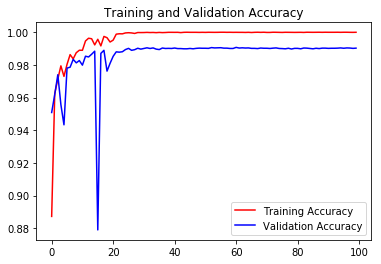

In [13]:
acc = history.history['acc']
loss = history.history['loss']
val_acc=history.history['val_acc']
val_loss=history.history['val_loss']

epochs=range(100)

plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_acc,'b-',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

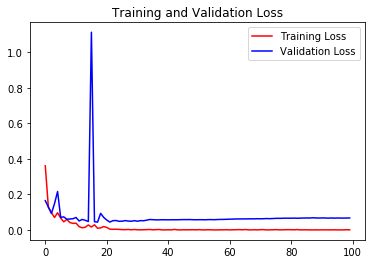

In [14]:
plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()